<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/cat_skeleton_detection_three_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.__version__
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 True


In [3]:
!pip show pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' &> /dev/null

Name: PyYAML
Version: 6.0
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: 
Required-by: albumentations, bokeh, dask, distributed, fastai, PyDrive


In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper

In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("cat_keypoints_train", {}, "/content/drive/MyDrive/Dataset/cats/annotations/person_keypoints_default.json", "/content/drive/MyDrive/Dataset/cats/images")

In [6]:
#MetadataCatalog.remove("person_keypoints_train")
#DatasetCatalog.remove("person_keypoints_train")

In [6]:
keypoint_names = ['nose', 'left_eye', 'right_eye']
keypoint_flip_map = [('left_eye', 'right_eye')]
keypoint_connection_rules = [('left_eye', 'left_eye', (102, 204, 255)),('nose', 'left_eye', (102, 204, 255)),('nose', 'right_eye', (102, 204, 255))]
MetadataCatalog.remove("cat_keypoints_train")

In [7]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("cat_keypoints_train").keypoint_connection_rules = keypoint_connection_rules
MetadataCatalog.get("cat_keypoints_train").thing_classes = ["threepoints"]
MetadataCatalog.get("cat_keypoints_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("cat_keypoints_train").keypoint_names = keypoint_names
MetadataCatalog.get("cat_keypoints_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("cat_keypoints_train").evaluator_type="coco"

In [8]:
cat_metadata = MetadataCatalog.get("cat_keypoints_train")
cat_metadata

Metadata(evaluator_type='coco', keypoint_connection_rules=[('left_eye', 'left_eye', (102, 204, 255)), ('nose', 'left_eye', (102, 204, 255)), ('nose', 'right_eye', (102, 204, 255))], keypoint_flip_map=[('left_eye', 'right_eye')], keypoint_names=['nose', 'left_eye', 'right_eye'], name='cat_keypoints_train', thing_classes=['threepoints'], thing_dataset_id_to_contiguous_id={1: 0})

In [9]:
dataset_dicts = DatasetCatalog.get("cat_keypoints_train")
dataset_dicts[0]

[03/04 07:50:55 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Dataset/cats/annotations/person_keypoints_default.json takes 1.53 seconds.
[03/04 07:50:55 d2.data.datasets.coco]: Loaded 309 images in COCO format from /content/drive/MyDrive/Dataset/cats/annotations/person_keypoints_default.json


{'file_name': '/content/drive/MyDrive/Dataset/cats/images/00000001_000.jpg',
 'height': 500,
 'width': 375,
 'image_id': 1,
 'annotations': [{'iscrowd': 0,
   'bbox': [177.27, 162.65, 63.58, 30.47],
   'keypoints': [200.16, 193.62, 2, 177.77, 163.15, 2, 241.35, 166.15, 2],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}

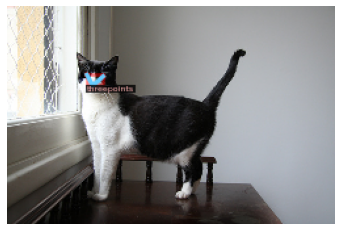

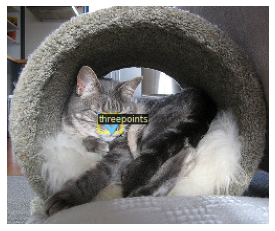

In [10]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

cat_metadata = MetadataCatalog.get("cat_keypoints_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=cat_metadata, scale=0.5)    
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# cfg.MODEL.DEVICE = "cpu"


cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/Base-Keypoint-RCNN-FPN.yaml"))
cfg.DATASETS.TRAIN = ("cat_keypoints_train",)
cfg.OUTPUT_DIR = '/content/drive/MyDrive/Dataset/output'
# cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Dataset/model_final.pth'

#cfg.DATASETS.TEST = ("hand_test",)  #Dataset 'hand_test' is empty in my case
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final_train.pth")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 8000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # person
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((3, 1), dtype=float).tolist()


In [13]:
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)

class CustomTrainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg):
        """
        Returns:
            iterable
        """

        cat_mapper = DatasetMapper(cfg, is_train=True, augmentations=[
                T.Resize((800, 800))
            ])
        dataloader = build_detection_train_loader(cfg,
            mapper=cat_mapper)
        return dataloader


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [15]:
del cfg

In [38]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/Base-Keypoint-RCNN-FPN.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Dataset/output/model_final.pth'  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.87
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3

predictor = DefaultPredictor(cfg)

[03/04 08:10:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Dataset/output/model_final.pth ...


In [39]:
im = cv2.imread("/content/drive/MyDrive/Dataset/微信图片_20230304160458.jpg")
outputs = predictor(im)
print(outputs["instances"])

Instances(num_instances=1, image_height=1442, image_width=1080, fields=[pred_boxes: Boxes(tensor([[466.9306, 503.0197, 617.6564, 587.4138]], device='cuda:0')), scores: tensor([0.8723], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_keypoints: tensor([[[5.2951e+02, 5.8674e+02, 5.3928e-02],
         [4.7972e+02, 5.0369e+02, 5.6238e-02],
         [6.1698e+02, 5.0369e+02, 1.4125e-01]]], device='cuda:0'), pred_keypoint_heatmaps: tensor([[[[-1.6468, -2.1358, -3.1138,  ..., -2.3096, -1.7610, -1.4868],
          [-1.2684, -1.9771, -3.3947,  ..., -2.5676, -1.8990, -1.5647],
          [-0.5114, -1.6598, -3.9566,  ..., -3.0838, -2.1750, -1.7206],
          ...,
          [-0.5681, -0.6166, -0.7137,  ..., -0.4925, -0.0833,  0.1213],
          [ 0.0943, -0.1218, -0.5539,  ..., -0.2318,  0.4037,  0.7214],
          [ 0.4255,  0.1256, -0.4741,  ..., -0.1014,  0.6472,  1.0215]],

         [[ 8.0592,  7.6826,  6.9294,  ..., -4.0752, -3.3505, -2.9881],
          [ 7.6006,  7.3614,  6

In [30]:
list(outputs['instances'].pred_classes)

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]

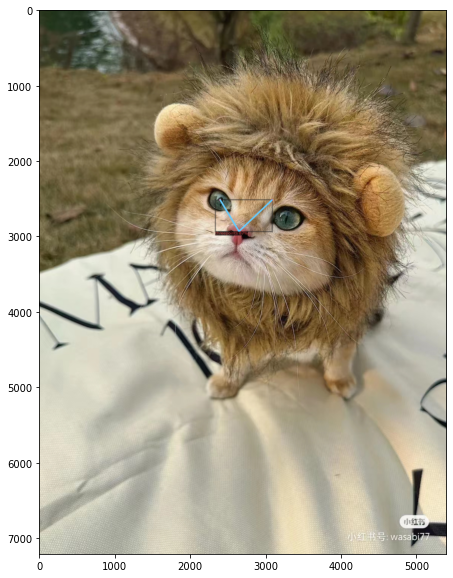

In [40]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1],
  metadata=cat_metadata, 
  scale=5, 
)


v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()


# o = outputs["instances"]
# #Create new class, boxes, scores & masks
# classes = o.pred_classes[idxofClass]
# scores = o.scores[idxofClass]
# boxes = o.pred_boxes[idxofClass]
# #masks = o.pred_masks[idxofClass]

# #Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
# obj = detectron2.structures.Instances(image_size=(480, 640))

# obj.set('pred_classes', classes)
# obj.set('scores', scores)
# obj.set('pred_boxes', boxes)

# obj